In [1]:
!pip install sktime
!pip install pmdarima

https://www.sktime.net/en/latest/users.html

Forecasting with sktime - https://www.sktime.net/en/latest/examples/01_forecasting.html

(No LSTM)

# Packages and plot functions

In [2]:
import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sktime

from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
np.random.seed(42)

plot_params = {'legend.fontsize': 20,
               'figure.figsize': (10, 8),
               'axes.labelsize':  15,
               'axes.titlesize':  20,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               'figure.dpi': 300}

plt.style.use('seaborn-v0_8')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))

In [4]:
def train_predict_plot(forecaster, fh, y_train, y_test, prophet=False, regression=False):

    if prophet:
        # Convert index to pd.DatetimeIndex
        z = y.copy()
        z = z.to_timestamp(freq="M")
        z_train, z_test = temporal_train_test_split(z, test_size=len(y_test))

        forecaster.fit(z_train)
        y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
        y_pred.index = y_test.index

    elif regression:
        forecaster.fit(y_train)
        y_pred = forecaster.predict(fh)

    else:
        forecaster.fit(y_train)
        y_pred = forecaster.predict(fh)

    plot_series(y_train, y_test, y_pred, labels=["Train", "Test", "Prediction"],
            colors=[color_dark_blue, color_light_blue, purple]);

    #print('MApE: {:.4f}'.format(mean_absolute_percentage_error(y_test, y_pred, symmetric=False)))

    return mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

# First Forecasting Example

In [5]:
y = pd.read_csv('df_NS.csv', index_col=0)['PC 3 - Curvature'].diff().dropna().to_frame()
y.index = pd.DatetimeIndex(y.index).to_period('D')
y = y.resample('M').sum()
y = y.cumsum()
#y = y.diff().dropna()
y_train, y_test = temporal_train_test_split(y, test_size=3*12)

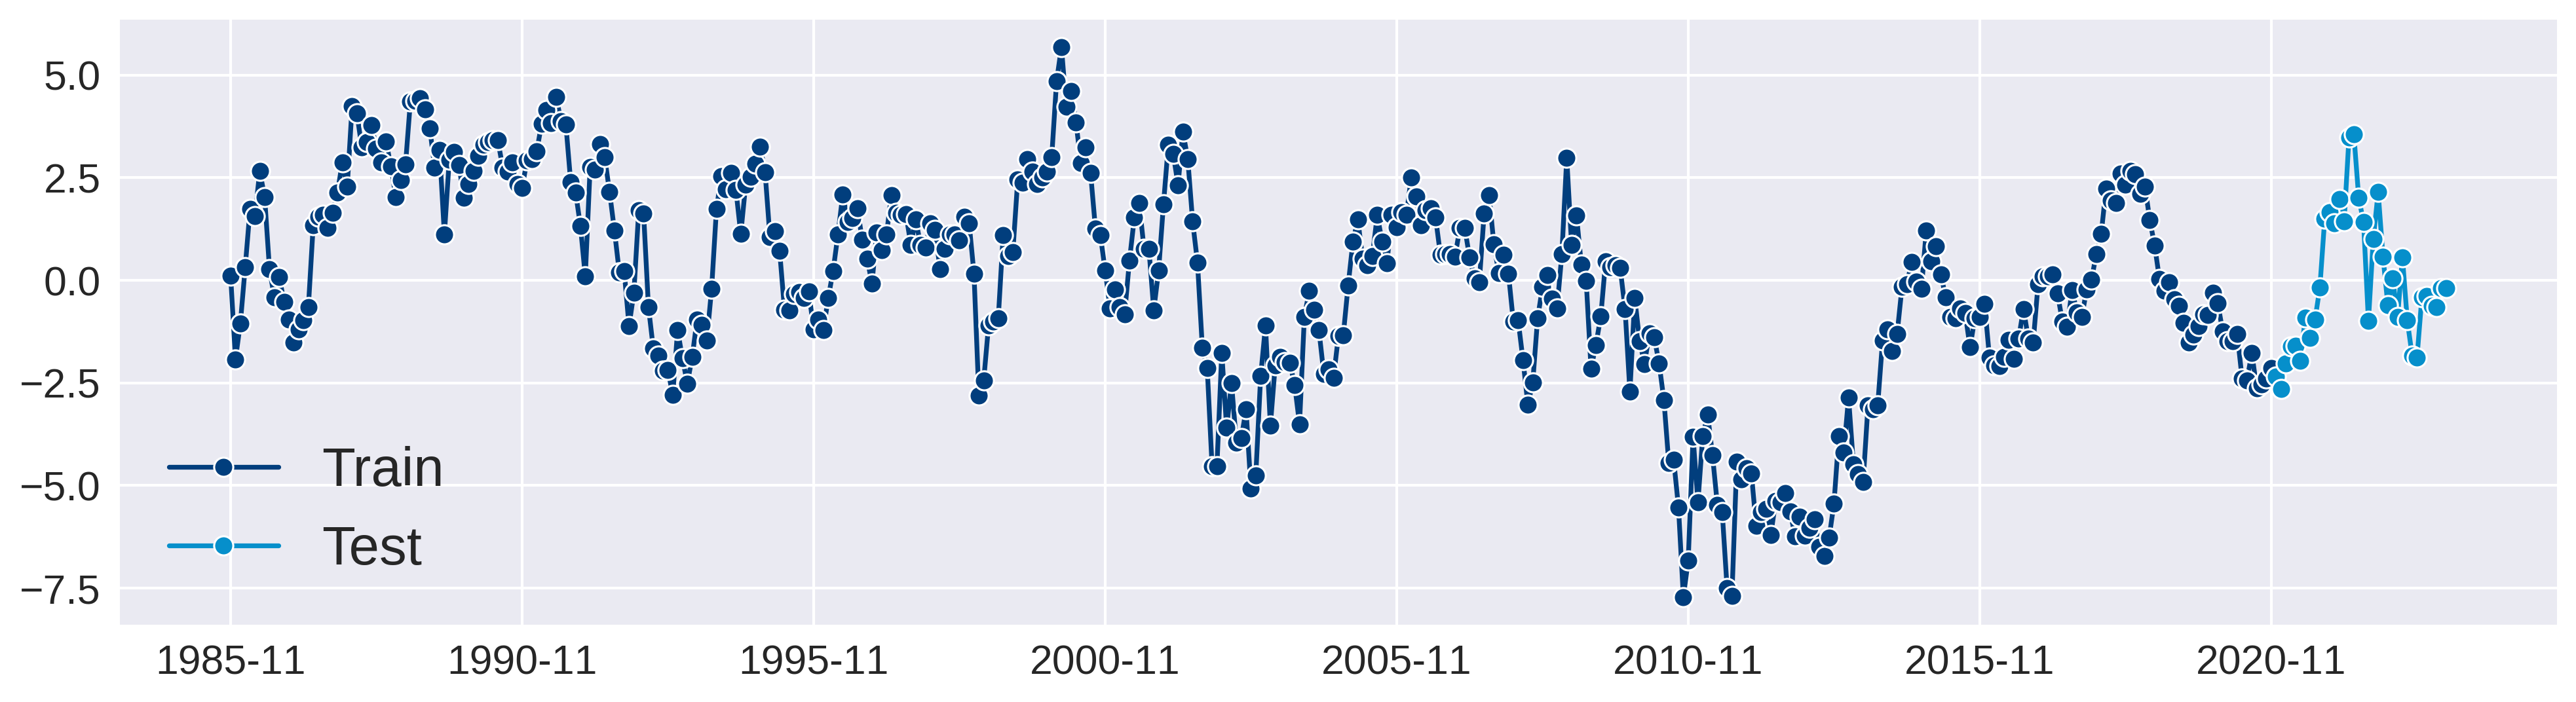

In [6]:
plot_series(y_train, y_test, labels=["Train", "Test"], colors=[color_dark_blue, color_light_blue]);

In [7]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [8]:
fh

ForecastingHorizon(['2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05',
             '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11',
             '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05',
             '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11',
             '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05',
             '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11'],
            dtype='period[M]', is_relative=False)

In [9]:
mape = pd.DataFrame(index=['mape'])

## Naive

In [10]:
naive_forecaster = NaiveForecaster(strategy="last")

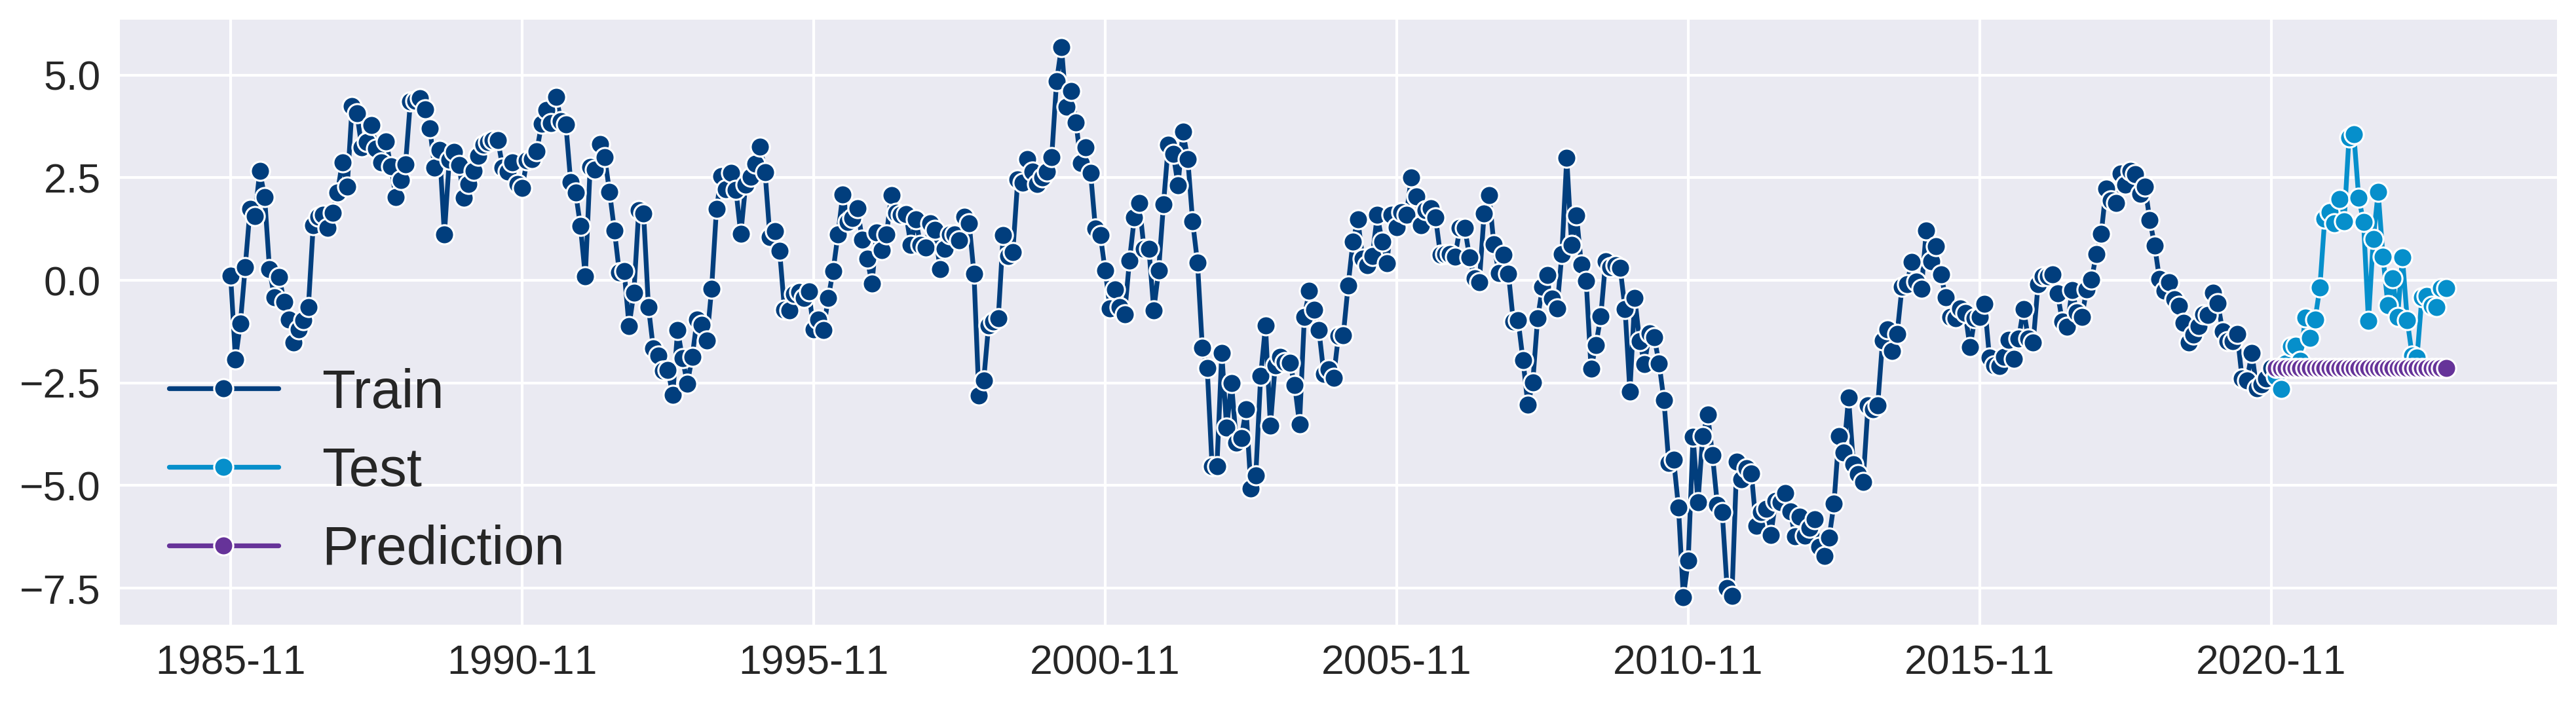

In [11]:
mape['Naive'] = train_predict_plot(naive_forecaster, fh, y_train, y_test)

##ARIMA

In [12]:
arima_forecaster = AutoARIMA(suppress_warnings=True)

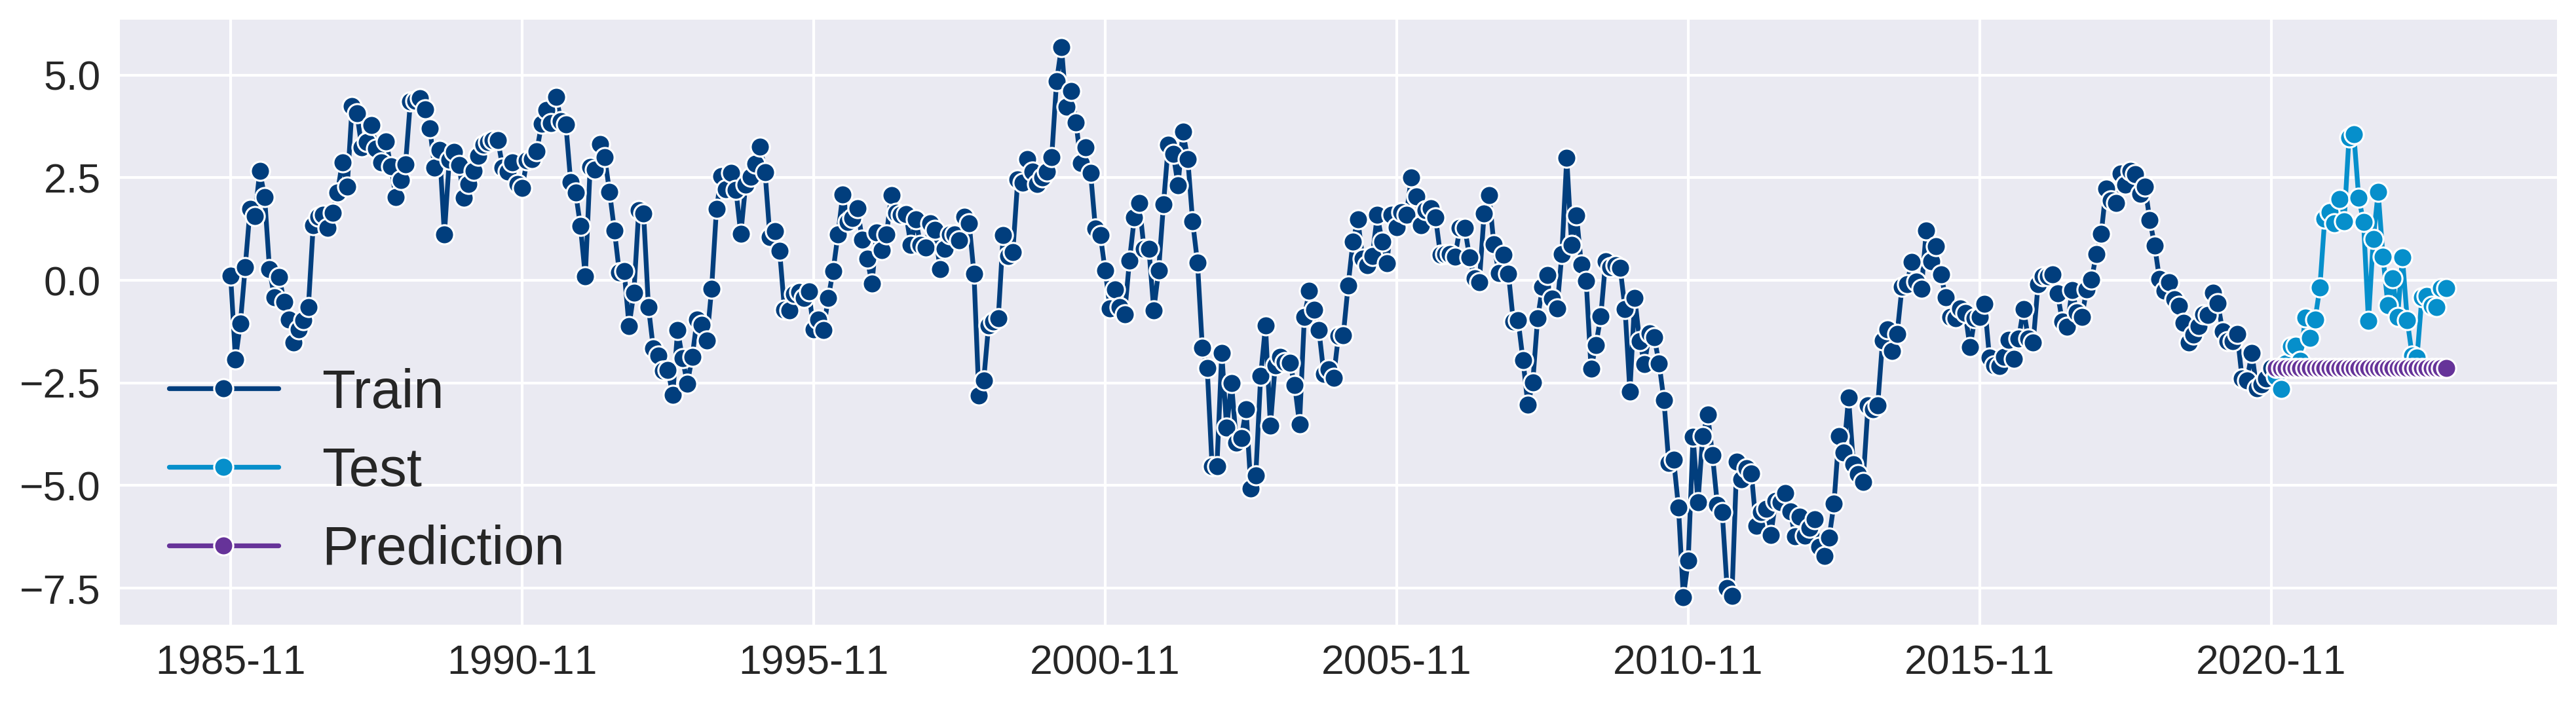

In [13]:
mape['ARIMA'] = train_predict_plot(arima_forecaster, fh, y_train, y_test)

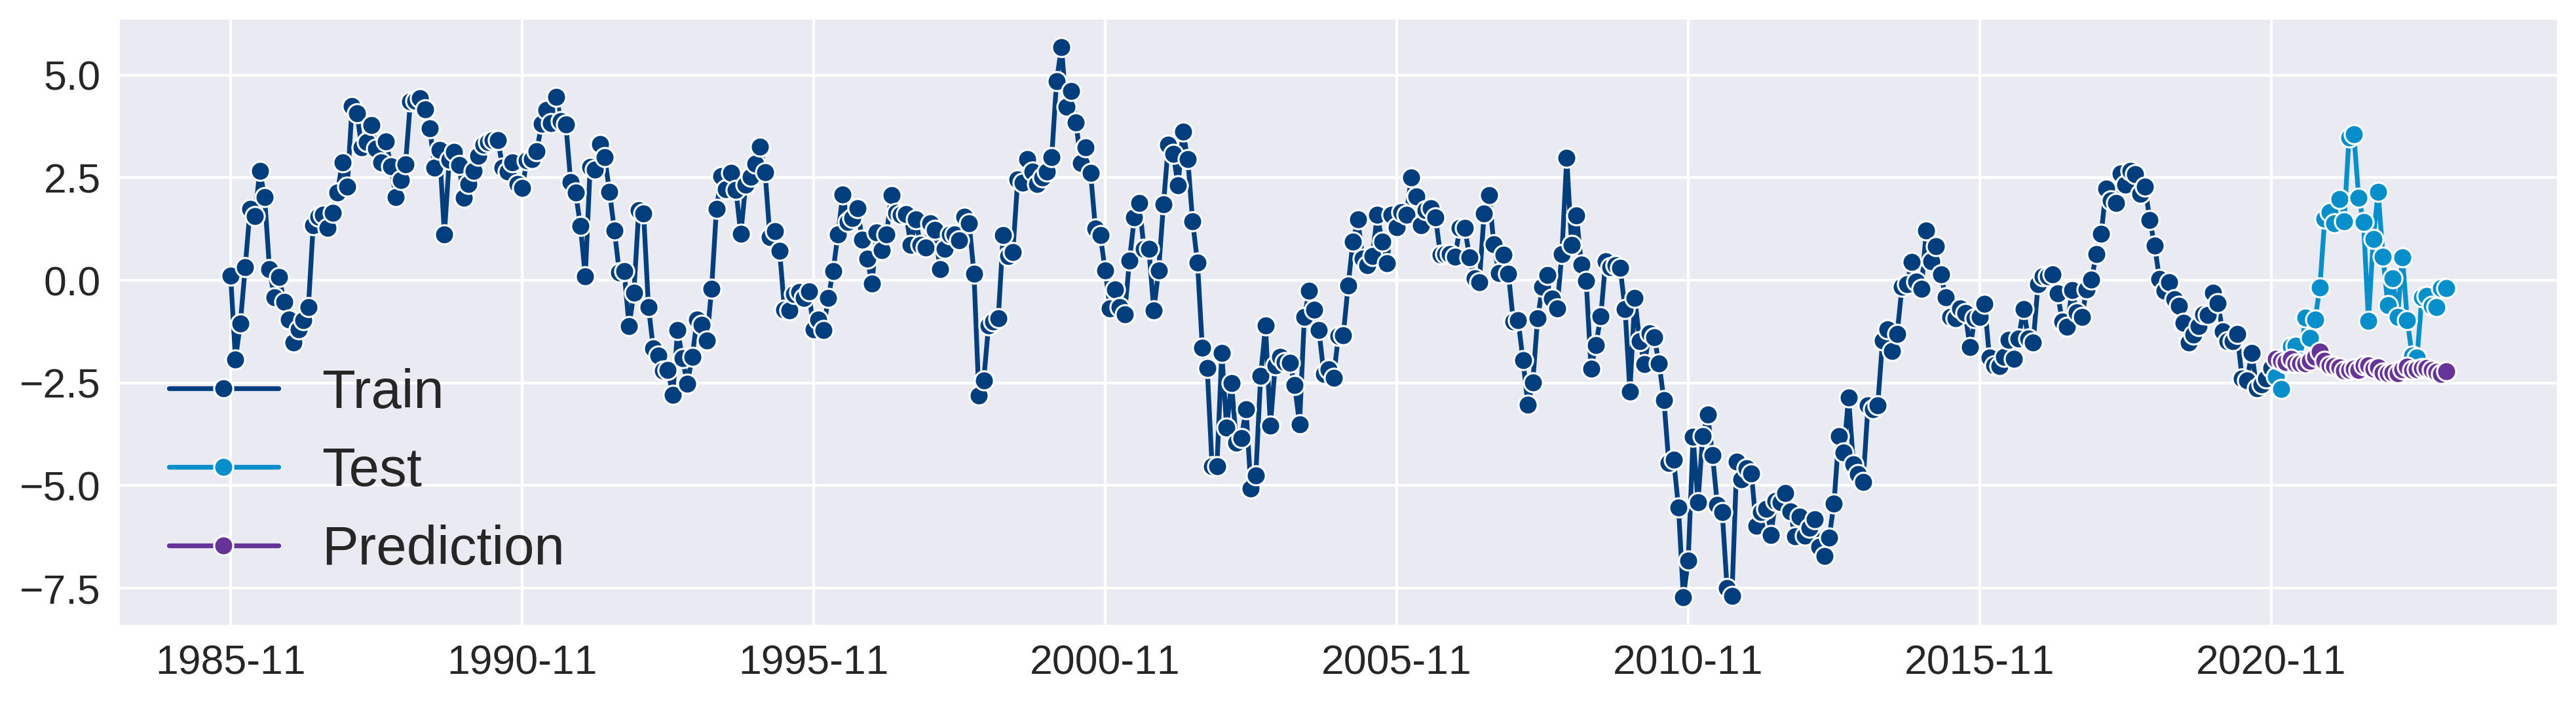

In [14]:
gb_regressor = GradientBoostingRegressor()
gb_forecaster = make_reduction(gb_regressor, window_length=3*12, strategy="recursive", windows_identical=False)

mape['Grad. Boosting'] = train_predict_plot(gb_forecaster, fh, y_train, y_test)

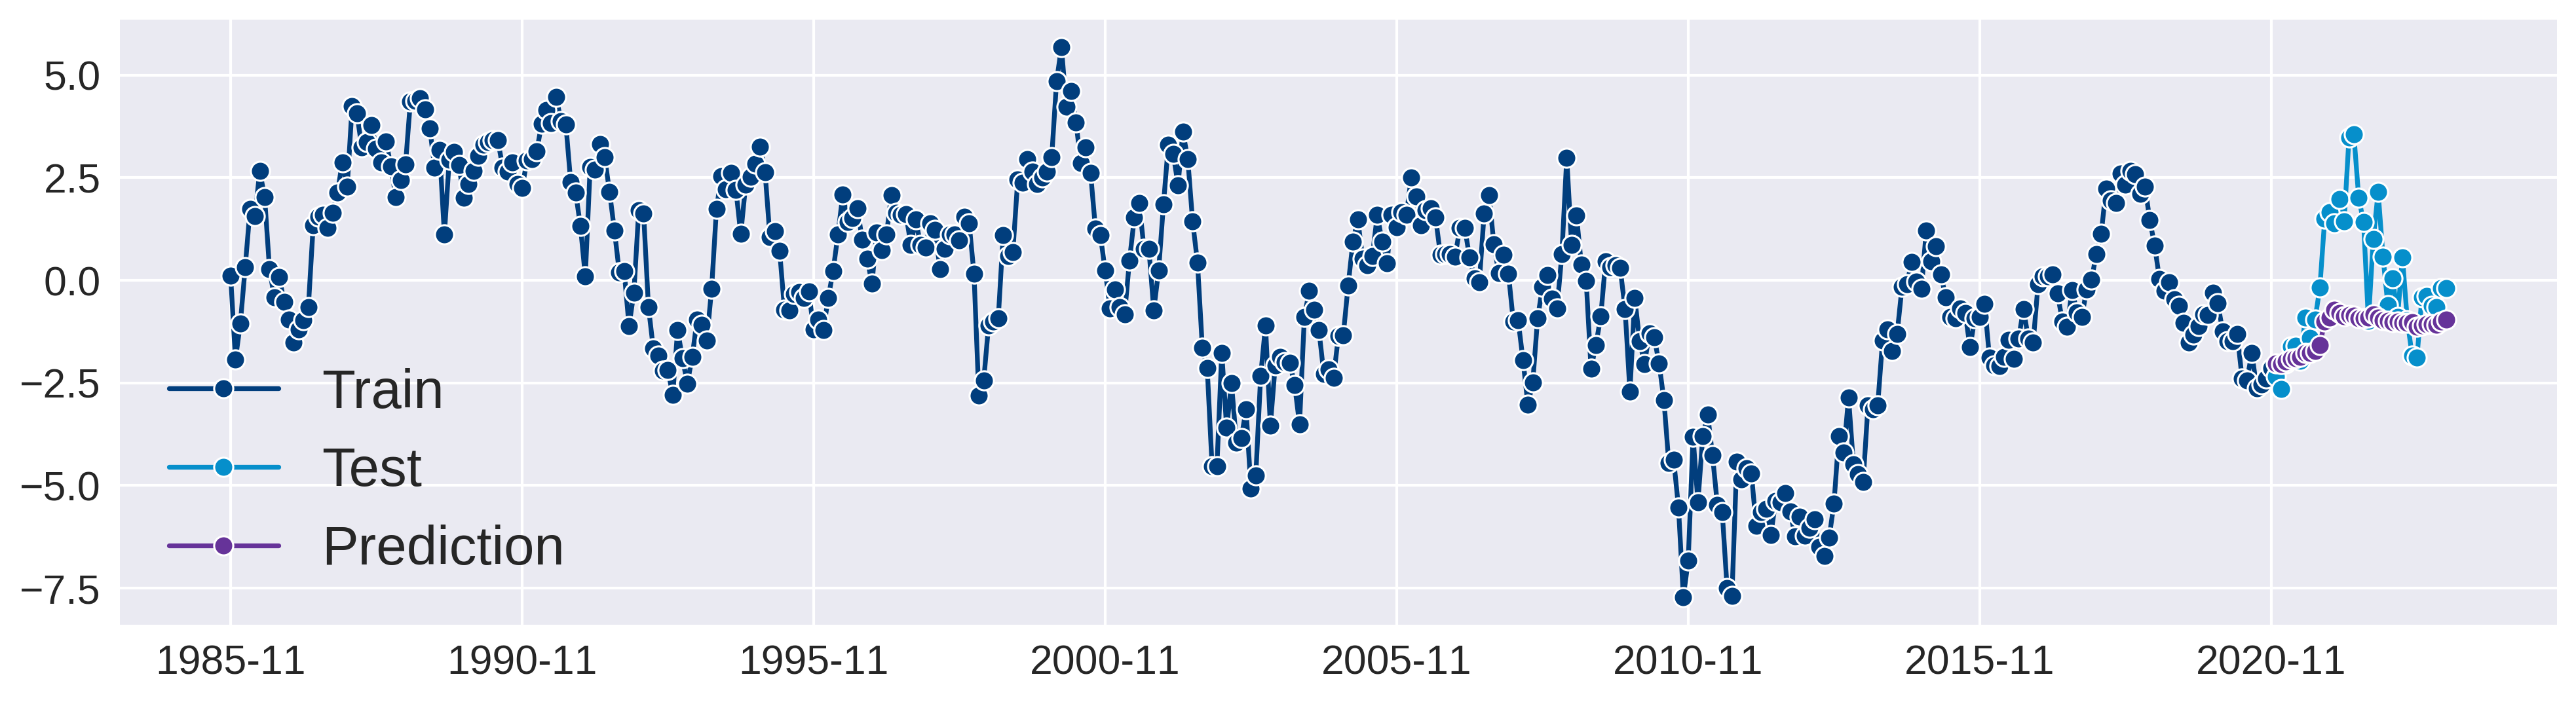

In [15]:
rf_regressor = RandomForestRegressor(n_estimators=200)
rf_forecaster = make_reduction(rf_regressor, window_length=3*12, strategy="recursive", windows_identical=False)

mape['RF'] = train_predict_plot(rf_forecaster, fh, y_train, y_test)

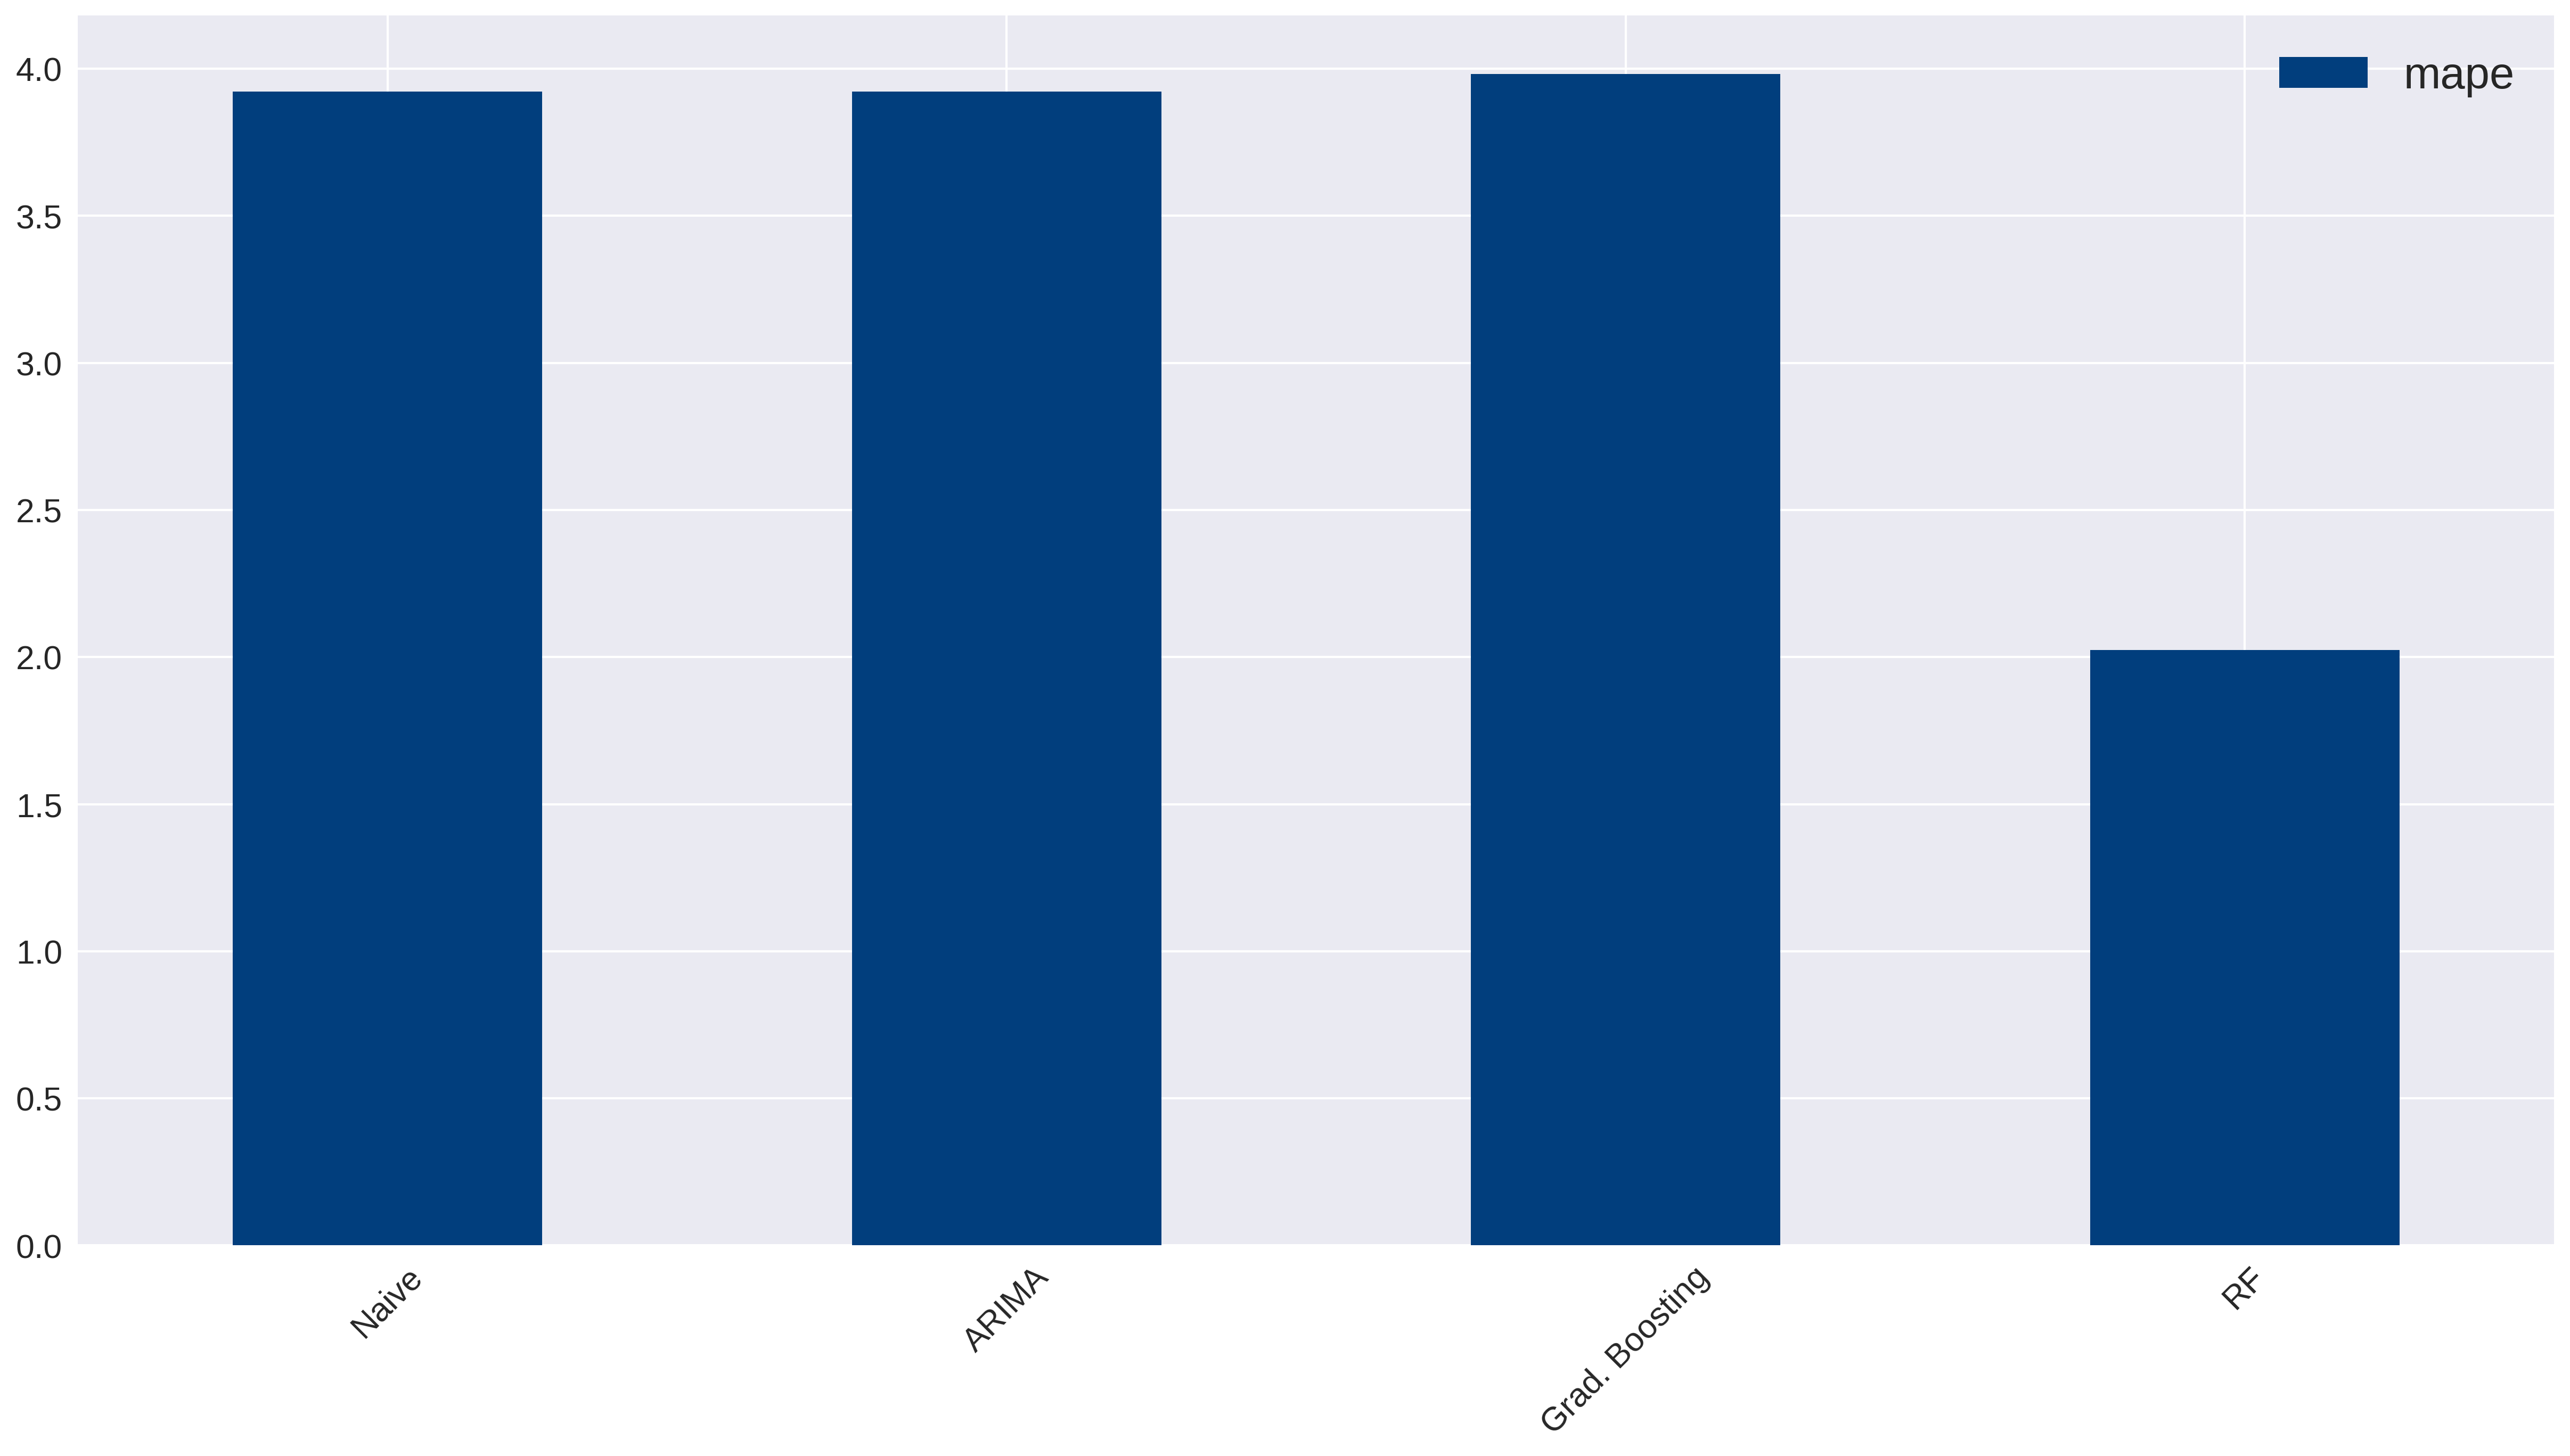

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
mape.T.plot.bar(rot=45, color=colors, ax=ax);